<a href="https://colab.research.google.com/github/AlexandrPetrov98/Cats-Dogs_face_detection/blob/main/Cats-Dogs_face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

train mIOU = 72%, valid mIOU = 62%, classification acc = 98.02%, avg cpu time = 0.37s, avg gpu time = 0.0025s, 2728 train, 656 valid

In [1]:
import pandas as pd
import numpy as np
import operator
import os
from tqdm.auto import tqdm
#import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
import cv2
from matplotlib import pyplot as plt
import random
import torch
from torch.autograd import Variable
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils
import torch.optim as optim
from torch import cuda
from PIL import Image, ImageDraw, ImageOps
from timeit import default_timer as timer
from IPython.display import clear_output
from __future__ import print_function, division
from skimage import io, transform

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import tarfile

tar = tarfile.open('/content/drive/MyDrive/cats_dogs_dataset.tar', "r:")
tar.extractall()
tar.close()

In [4]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [5]:
def imgandbbox(filename):
   
  img = Image.open(filename+".jpg")

  f = open(filename+".txt", "r")
  bbox =  list(map(int,f.readline().split()))
 
  
  draw = ImageDraw.Draw(img)
  draw.rectangle((bbox[1], bbox[2], bbox[3], bbox[4]), outline=(255, 255, 0))
  #imshow(img)
  

In [6]:
imgandbbox("Egyptian_Mau_128")

Импорт pd фреймов

In [7]:
df_train = pd.read_pickle("/content/drive/MyDrive/df_train.pkl")
df_valid = pd.read_pickle("/content/drive/MyDrive/df_valid.pkl")

Создание фреймов

In [8]:
cats, dogs = 0, 0
df_train = pd.DataFrame(columns=('Imagename', 'Class', 'Bbox'))
df_valid = pd.DataFrame(columns=('Imagename', 'Class', 'Bbox'))
for filename in os.listdir("/content"):
    if filename.endswith(".txt"):
      f = open(filename, "r")
      try:

        name = filename
        imgandbbox(name.replace('.txt', ''))
        txt =  list(map(int,f.readline().split()))
        if txt[0] == 1 and cats<850:      
          clas = [1,0]
          bbox = txt[1 :]
          df_train.loc[len(df_train.index)] = [filename.replace('txt', 'jpg'), clas, bbox]
          cats+=1
        else:
      
        
          if txt[0] == 2 and dogs<1878:
            clas = [0,1]
            bbox = txt[1 :]
            df_train.loc[len(df_train.index)] = [filename.replace('txt', 'jpg'), clas, bbox]

            dogs+=1
          
          else:
            if txt[0] == 1:      
              clas = [1,0]
            else:
              clas = [0,1]
            bbox = txt[1 :]
            df_valid.loc[len(df_valid.index)] = [filename.replace('txt', 'jpg'), clas, bbox]
      except:
        print("found")
        pass

display(df_train)
display(df_valid)
cats, dogs


found


,Imagename,Class,Bbox
0,english_cocker_spaniel_188.jpg,"[0, 1]","[99, 57, 281, 291]"
1,pug_140.jpg,"[0, 1]","[90, 1, 231, 106]"
2,japanese_chin_187.jpg,"[0, 1]","[256, 88, 478, 278]"
3,leonberger_106.jpg,"[0, 1]","[17, 107, 319, 378]"
4,Persian_129.jpg,"[1, 0]","[121, 32, 250, 171]"
...,...,...,...
2723,yorkshire_terrier_14.jpg,"[0, 1]","[88, 17, 226, 205]"
2724,japanese_chin_160.jpg,"[0, 1]","[56, 46, 356, 250]"
2725,samoyed_101.jpg,"[0, 1]","[170, 87, 222, 159]"
2726,newfoundland_168.jpg,"[0, 1]","[193, 85, 305, 179]"


,Imagename,Class,Bbox
0,Bombay_19.jpg,"[1, 0]","[117, 25, 314, 227]"
1,Bengal_187.jpg,"[1, 0]","[216, 9, 315, 118]"
2,Persian_132.jpg,"[1, 0]","[28, 81, 325, 380]"
3,Abyssinian_105.jpg,"[1, 0]","[237, 101, 373, 227]"
4,Bombay_191.jpg,"[1, 0]","[37, 44, 175, 189]"
...,...,...,...
651,keeshond_145.jpg,"[0, 1]","[59, 45, 280, 310]"
652,staffordshire_bull_terrier_195.jpg,"[0, 1]","[91, 6, 438, 350]"
653,yorkshire_terrier_179.jpg,"[0, 1]","[103, 68, 305, 235]"
654,staffordshire_bull_terrier_136.jpg,"[0, 1]","[140, 44, 459, 278]"


(850, 1878)

In [9]:
import pandas as pd
df_train.to_pickle("/content/model_checkpoint/df_train.pkl")
df_valid.to_pickle("/content/model_checkpoint/df_valid.pkl")

FileNotFoundError: ignored

In [10]:
cats, dogs = 0, 0
for filename in os.listdir("/content"):
    if filename.endswith(".txt"):
      f = open(filename, "r")
      txt =  list(map(int,f.readline().split()))
      if txt[0] == 1:
        cats+=1
      else:
        dogs+=1
print(cats,dogs)




1037 2348


Класс датасета

In [11]:
class Cats_Dogs_Dataset(Dataset):
    """Cats_Dogs dataset."""

    def __init__(self, imnames, clases, boxes,  transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.bboxs_frame = boxes
        self.classes_frame = clases
        self.image_frame = imnames
        self.transform = transform

    def __len__(self):
        return len(self.bboxs_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        clas = self.classes_frame[idx]
        img_name = self.image_frame[idx]
        image = io.imread(img_name)
        bbox = self.bboxs_frame[idx]
        bbox = np.array([bbox])
        bbox = bbox.astype('float').reshape(-1, 2)
        
        sample = {'image': image,'class':clas, 'bbox': bbox}

        if self.transform:
            sample = self.transform(sample)

        return sample

Создание датасета

In [12]:
CD_train = Cats_Dogs_Dataset(df_train['Imagename'],df_train['Class'],df_train['Bbox'])
CD_valid = Cats_Dogs_Dataset(df_valid['Imagename'],df_valid['Class'],df_valid['Bbox'])

Аугментации

In [13]:
class RandomFlipH(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, probab):
            self.probability = probab
        

    def __call__(self, sample):
        image, bbox = sample['image'], sample['bbox']
        
        h, w = image.shape[:2]
        #print(image.shape)
        if self.probability >= np.random.random_sample():
          image = cv2.flip(image, 1)
          x1,y1,x2,y2 = bbox[0][0], bbox[0][1], bbox[1][0], bbox[1][1]
          
          bbox[0][0] = w - x2
          bbox[0][1] = y1
          bbox[1][0] = w - x1
          bbox[1][1] = y2
          
        #print(bbox)

        
        return {'image': image,'class':sample['class'], 'bbox': bbox}

class RandomFlipV(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, probab):
            self.probability = probab
        

    def __call__(self, sample):
        image, bbox = sample['image'], sample['bbox']
        
        h, w = image.shape[:2]
        #print(image.shape)
        if self.probability >= np.random.random_sample():
          image = cv2.flip(image, 0)
          x1,y1,x2,y2 = bbox[0][0], bbox[0][1], bbox[1][0], bbox[1][1]
          
          bbox[0][0] = x1
          bbox[0][1] = h - y2
          bbox[1][0] = x2
          bbox[1][1] = h - y1
         
        #print(bbox)

        
        return {'image': image,'class':sample['class'], 'bbox': bbox}

class Rescale_nornd(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, bbox = sample['image'], sample['bbox']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for bbox because for images,
        # x and y axes are axis 1 and 0 respectively
        bbox = bbox * [new_w / w, new_h / h]

        return {'image': img, 'class':sample['class'], 'bbox': bbox}

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size + np.random.randint(-30,30)

    def __call__(self, sample):
        image, bbox = sample['image'], sample['bbox']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for bbox because for images,
        # x and y axes are axis 1 and 0 respectively
        bbox = bbox * [new_w / w, new_h / h]

        return {'image': img, 'class':sample['class'], 'bbox': bbox}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, bbox = sample['image'], sample['bbox']
        x1,y1,x2,y2 = bbox[0][0], bbox[0][1], bbox[1][0], bbox[1][1]
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        cx = x2-((x2-x1)/2)
        cy = y2-((y2-y1)/2)
        
        top = np.random.randint(abs(h - new_h)/1.5, abs(h - new_h))
        left =  np.random.randint((w - new_w)/1.5, w - new_w) #int((((x2-x1)/2)/w)*new_w) #int(((x2-x1)/w)*new_w) #
        
        image = image[top: top + new_h,
                      left: left + new_w]
        
        bbox = bbox - [left, top]

        

        

        if bbox[0][0] < 0 : bbox[0][0] = 0
        if bbox[1][0] < 0 : bbox[1][0] = 0
        if bbox[0][1] < 0 : bbox[0][1] = 0
        if bbox[1][1] < 0 : bbox[1][1] = 0

        if bbox[0][0] > 224 : bbox[0][0] = 224
        if bbox[1][0] > 224 : bbox[1][0] = 224
        if bbox[0][1] > 224 : bbox[0][1] = 224
        if bbox[1][1] > 224 : bbox[1][1] = 224
        
        x1,y1,x2,y2 = bbox[0][0], bbox[0][1], bbox[1][0], bbox[1][1]

        

        return {'image': image,'class':sample['class'], 'bbox': bbox}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, bbox, clas = sample['image'], sample['bbox'],sample['class']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        clas = np.array([clas])
        bbox = np.concatenate((clas, (bbox/224)*6), axis=0) # ИЗМЕНЕНИЕ
        if (bbox[2][0]-bbox[1][0])*(bbox[2][1]-bbox[1][1])< 0.1:
          bbox[1][0] = 0
          bbox[2][0] = 0
          bbox[1][1] = 0
          bbox[2][1] = 0
        bbox = torch.from_numpy(bbox)
        #print(image.shape)
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                #'class':torch.from_numpy(clas.astype('float')),
                'bbox': torch.cat((bbox[0],bbox[1],bbox[2]),0) }

In [14]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [15]:
def show_bbox(image, bboxs):
    """Show image with landmarks"""
    fig, ax = plt.subplots()
    plt.imshow(image)
    x = bboxs[1][0]
    y = bboxs[0][1]
    h = bboxs[1][1] - bboxs[0][1]
    w = bboxs[0][0] - bboxs[1][0]
    ax.add_patch(
     patches.Rectangle( (x, y), w, h, edgecolor = 'red', facecolor = 'red', fill=False ) )
    #plt.scatter(bboxs[:, 0], bboxs[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated



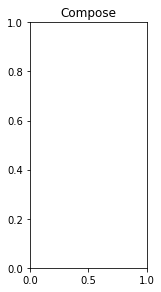

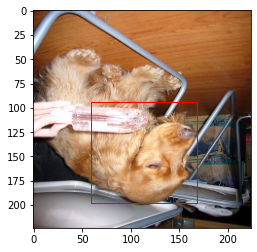

[[ 59.136       93.632     ]
 [167.85066667 198.464     ]] (224, 224, 3)


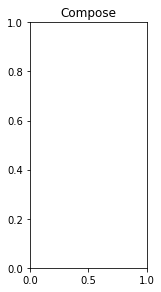

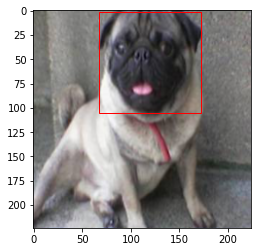

[[ 67.2          0.99555556]
 [172.48       105.52888889]] (224, 224, 3)


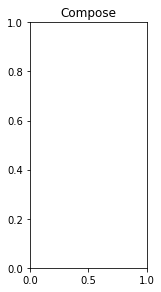

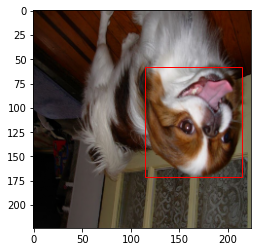

[[114.688       57.94133333]
 [214.144      171.43466667]] (224, 224, 3)


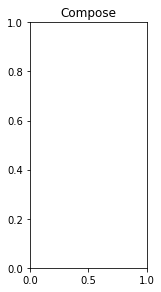

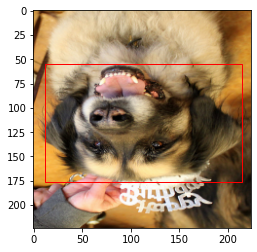

[[ 11.43543544  54.656     ]
 [214.58258258 176.064     ]] (224, 224, 3)


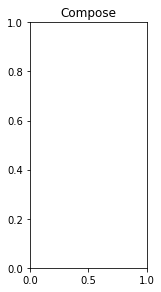

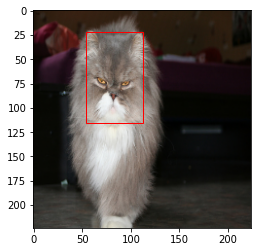

[[ 54.208       21.52552553]
 [112.         115.02702703]] (224, 224, 3)


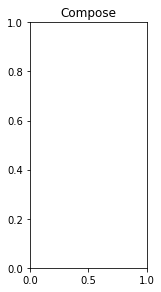

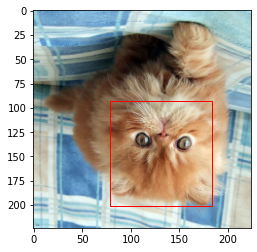

[[ 78.848       92.84210526]
 [183.232      200.9122807 ]] (224, 224, 3)


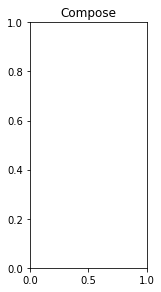

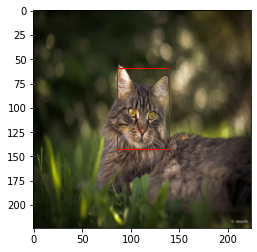

[[ 86.016       59.1951952 ]
 [138.88       142.60660661]] (224, 224, 3)


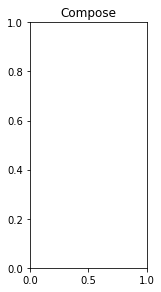

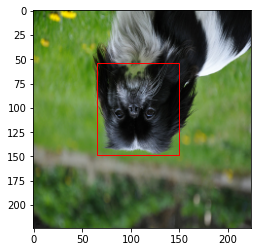

[[ 65.408       53.97590361]
 [149.184      148.43373494]] (224, 224, 3)


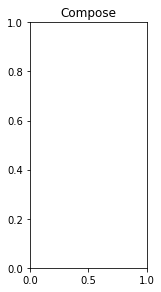

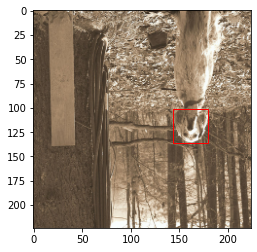

[[142.912 101.36 ]
 [179.648 136.64 ]] (224, 224, 3)


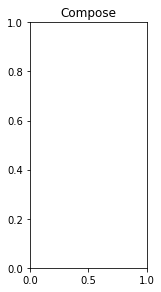

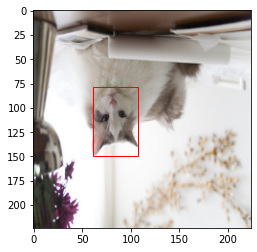

[[ 60.928       78.7027027 ]
 [107.52       149.33333333]] (224, 224, 3)


In [16]:
import matplotlib.patches as patches
scale = Rescale(226)
crop = RandomCrop(224)
composed = transforms.Compose([RandomFlipV(0.5),RandomFlipV(0.5),Rescale_nornd((224,224))])#RandomFlipV(0.4),RandomFlipH(0.4),Rescale(250), RandomCrop(224)
RandomFlipV(0.4),RandomFlipH(0.4),
# Apply each of the above transforms on sample.
fig = plt.figure()
for i in range(0,10):
  sample = CD_train[i]
  for i, tsfrm in enumerate([ composed]): #scale, crop,
      transformed_sample = tsfrm(sample)

      ax = plt.subplot(1, 3, i + 1)
      plt.tight_layout()
      ax.set_title(type(tsfrm).__name__)
      show_bbox(transformed_sample['image'],transformed_sample['bbox'])
      print(transformed_sample['bbox'],transformed_sample['image'].shape)

plt.show()

In [17]:
transformed_dataset = Cats_Dogs_Dataset(df_train['Imagename'],df_train['Class'],df_train['Bbox'],
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                               
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['bbox'].size())
    #print(torch.cat((sample['bbox'][0],sample['bbox'][1],sample['bbox'][2]),0))
    print(sample['bbox'])

    if i == 0:
        break

0 torch.Size([3, 224, 224]) torch.Size([6])
tensor([0.0000, 1.0000, 1.1068, 0.0000, 4.4218, 2.3807], dtype=torch.float64)


In [18]:
batch_size=32
dataloaders = {
    'train': DataLoader(Cats_Dogs_Dataset(df_train['Imagename'],df_train['Class'],df_train['Bbox'],
                                           transform=transforms.Compose([
                                               RandomFlipV(0.4),
                                               RandomFlipH(0.4),
                                               Rescale_nornd((224,224)),                          
                                               #Rescale(254),
                                               #RandomCrop(224),
                                               ToTensor(),
                                               
                                               
                                           ])), batch_size=batch_size, shuffle=True),
    'val': DataLoader(Cats_Dogs_Dataset(df_valid['Imagename'],df_valid['Class'],df_valid['Bbox'],
                                           transform=transforms.Compose([
                                               Rescale_nornd((224,224)),
                                               #RandomCrop(224),
                                               ToTensor()
                                               
                                           ])), batch_size=batch_size, shuffle=True),
    
}#'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)

In [19]:
trainiter = iter(dataloaders['train'])
features= next(trainiter)
features['bbox'][0]

tensor([0.0000, 1.0000, 1.9200, 3.5200, 3.4800, 5.8080], dtype=torch.float64)

In [20]:
class BB_model_resnet(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        #print("RESNET")
        #print(resnet)
        
        for param in resnet.parameters():
          param.requires_grad = False
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 2))
        self.bb = nn.Sequential(nn.BatchNorm1d(512),
                                nn.Linear(512, 512),nn.ReLU(),
                                nn.Linear(512, 512),nn.ReLU(),
                                nn.Linear(512, 512),nn.ReLU(),
                                nn.Linear(512, 512),nn.ReLU(),
                                nn.Linear(512, 512),nn.ReLU(),
                                nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

Класс модели на VGG16

In [22]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.vgg16(pretrained=True)
        #print("RESNET")
        #print(resnet)
        resnet.classifier = nn.Sequential(*list(resnet.classifier.children())[:-5])
        for param in resnet.parameters():
          param.requires_grad = False
        
        layers = list(resnet.children())[:8]
        #print(layers)
        self.features1 = resnet#.features, resnet.avgpool,resnet.classifier[:4] #(*layers[:2])
        print(self.features1)
        #self.features2 = nn.Sequential(*layers[2:])
        self.classifier = nn.Sequential(nn.Linear(4096, 2))
        self.bb = nn.Sequential(nn.Linear(4096, 1024,bias=True),nn.ReLU(),
                                nn.Linear(1024, 1024,bias=True),nn.ReLU(),
                                nn.Linear(1024, 1024,bias=True),nn.ReLU(),
                                nn.Linear(1024, 1024,bias=True),nn.ReLU(),
                                nn.Linear(1024, 1024,bias=True),nn.ReLU(),
                                nn.Linear(1024, 1024,bias=True),nn.ReLU(),
                                nn.Linear(1024, 1024,bias=True),nn.ReLU(),
                                nn.Linear(1024, 1024,bias=True),nn.ReLU(),
                                nn.Linear(1024, 4,bias=True))
        
    def forward(self, x):
        x = self.features1(x)
        
        #x = self.features2(x)
        x = F.relu(x)
        #x = nn.AdaptiveAvgPool2d((1,1))(x)
        #x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

Создание модели

In [23]:
model = BB_model()
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

BB_model(
  (features1): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (

In [24]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

129,034,054 total parameters.
11,554,822 training parameters.


In [25]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

NameError: ignored

Функции mIOU

In [26]:
def IOU(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou


In [27]:
def batch_mIOU(out, tar):
  res = 0
  for i in range(len(tar)):
    res+=IOU(out[i],tar[i])
  
  return res/(len(tar))


Загрузка обученной модели

In [28]:
model.load_state_dict(torch.load("/content/drive/MyDrive/vggobj-transfer-new7261.pt"))

<All keys matched successfully>

In [29]:
def tens_show_bbox(image, bboxs):
    """Show image with landmarks"""
    fig, ax = plt.subplots()
    plt.imshow(image)
    x = bboxs[2] #[,][,]
    y = bboxs[1]
    h = bboxs[3] - bboxs[1]
    w = bboxs[0] - bboxs[2]
    ax.add_patch(
     patches.Rectangle( (x, y), w, h, edgecolor = 'red', facecolor = 'red', fill=False ) )
    #plt.scatter(bboxs[:, 0], bboxs[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [30]:
model = model.to('cpu')
model.eval() 

BB_model(
  (features1): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (

Среднее время одногоинференс прохода на cpu - 0.37

Forward time = 0.3658726215362549
IOU = 36.122821644542846 %
AVG time = 0.18293631076812744
Forward time = 0.3715949058532715
IOU = 47.369769784608984 %
AVG time = 0.24582250912984213


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Forward time = 0.38116979598999023
IOU = 61.94361119402772 %
AVG time = 0.27965933084487915
Forward time = 0.36632204055786133
IOU = 73.96101764909118 %
AVG time = 0.2969918727874756
Forward time = 0.3707423210144043
IOU = 72.21589719258439 %
AVG time = 0.30928361415863037
Forward time = 0.37187647819519043
IOU = 35.3664713898549 %
AVG time = 0.31822545187813894
Forward time = 0.3704850673675537
IOU = 50.348630262220716 %
AVG time = 0.3247579038143158
Forward time = 0.3695812225341797
IOU = 80.62646028694694 %
AVG time = 0.3297382725609673
Forward time = 0.3675351142883301
IOU = 55.4325071571386 %
AVG time = 0.3335179567337036
Forward time = 0.3737218379974365
IOU = 66.77898469604268 %
AVG time = 0.3371728550304066
Forward time = 0.36525988578796387
IOU = 32.33842847434155 %
AVG time = 0.3395134409268697
Forward time = 0.36589884757995605
IOU = 16.7933008226753 %
AVG time = 0.34154308759249175
Forward time = 0.37700653076171875
IOU = 64.16239501965111 %
AVG time = 0.344076190676008
For

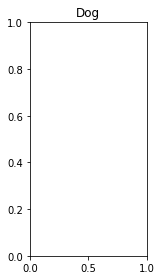

In [ ]:
import time
avgtime = 0
cnt = 1
scale = Rescale(226)
crop = RandomCrop(224)
composed = transforms.Compose([Rescale_nornd((224,224))])#RandomCrop(224)
modcomposed = transforms.Compose([Rescale_nornd((224,224)), ToTensor()])#RandomFlipH(1),

# Apply each of the above transforms on sample.
fig = plt.figure()
for i in range(450,460):#len(CD_valid)
  sample = CD_valid[i]
  cnt+= 1
  for i, tsfrm in enumerate([ modcomposed]): 
      transformed_sample = tsfrm(sample)
      tr = composed(sample)
      
      

      start = time.time()
      
      
      output = model(transformed_sample["image"].unsqueeze(0).float())
      end = time.time()

      avgtime += end - start
      print("Forward time =",end - start)
      clas, bbox = output
      
      index = torch.argmax(clas)
      if index == 0:
        name ="Cat"
      else:
        name ="Dog"
      
      bbox = (bbox*224)/6
      #print(bbox)
      ax = plt.subplot(1, 3, i + 1)
      plt.tight_layout()
      ax.set_title(name)
      
      tens_show_bbox(tr["image"],bbox[0].detach().numpy())# для проверки времени прохода лучше закомментировать
      print("IOU =",100*IOU(bbox[0].detach().numpy(),np.concatenate((tr['bbox'][0], tr['bbox'][1]), axis=0)),"%")
      print("AVG time =",avgtime/(cnt))
      
      #print(transformed_sample['bbox'],transformed_sample['image'].shape)

plt.show()

In [32]:
model = model.to('cuda')
model.eval() 

BB_model(
  (features1): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (

Среднее время одного инференс прохода на gpu - 0.0025

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


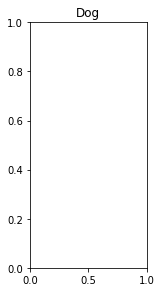

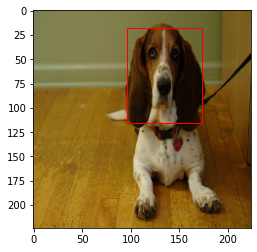

IOU = 84.3590339947675 %
Forward time = 0.11596846580505371
AVG time = 0.057984232902526855


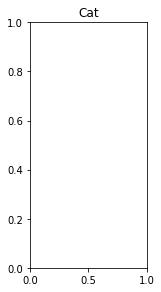

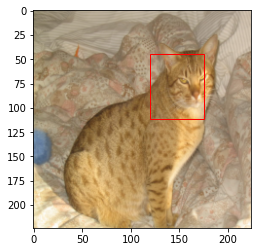

IOU = 45.31878220666968 %
Forward time = 0.00446629524230957
AVG time = 0.040144920349121094


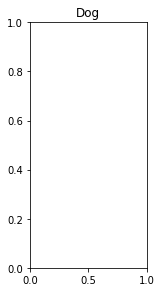

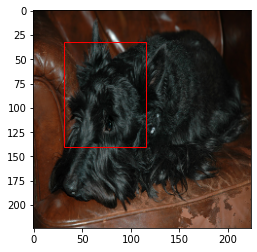

IOU = 46.09278934050728 %
Forward time = 0.004151105880737305
AVG time = 0.031146466732025146


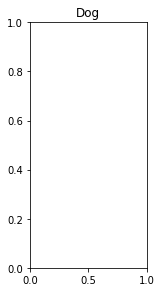

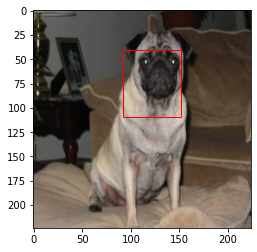

IOU = 46.40541829737423 %
Forward time = 0.005278348922729492
AVG time = 0.025972843170166016


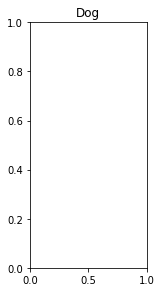

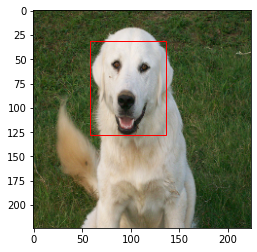

IOU = 74.01124739409128 %
Forward time = 0.004124164581298828
AVG time = 0.022331396738688152


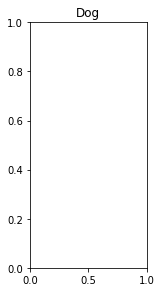

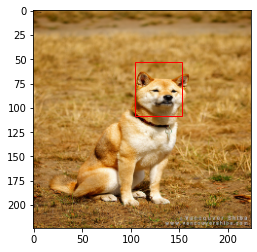

IOU = 60.39117157566991 %
Forward time = 0.004288911819458008
AVG time = 0.019753898893083845


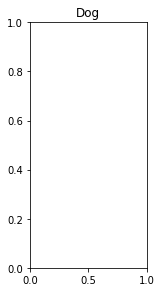

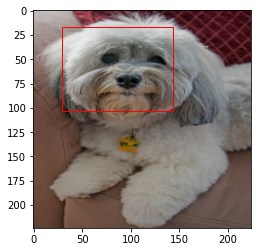

IOU = 48.28530650159394 %
Forward time = 0.004154205322265625
AVG time = 0.017803937196731567


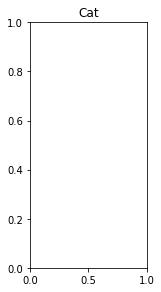

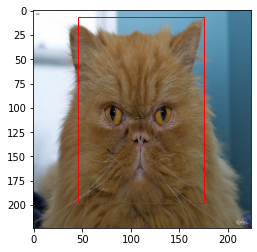

IOU = 89.85834209254837 %
Forward time = 0.004055976867675781
AVG time = 0.016276386049058702


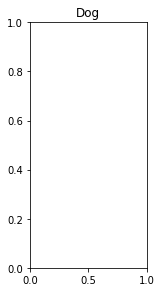

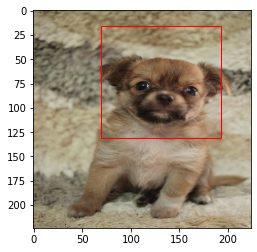

IOU = 54.98461540657533 %
Forward time = 0.004030704498291016
AVG time = 0.015051817893981934


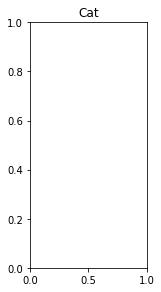

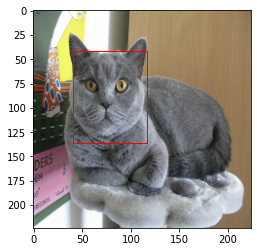

IOU = 73.88099151463291 %
Forward time = 0.003988981246948242
AVG time = 0.014046105471524324


In [33]:
import time
avgtime = 0
cnt = 1
scale = Rescale(226)
crop = RandomCrop(224)
composed = transforms.Compose([Rescale_nornd((224,224))])#RandomCrop(224)
modcomposed = transforms.Compose([Rescale_nornd((224,224)), ToTensor()])#RandomFlipH(1),

# Apply each of the above transforms on sample.
fig = plt.figure()
for i in range(450,460):#len(CD_valid)
  sample = CD_valid[i]
  cnt+= 1
  for i, tsfrm in enumerate([ modcomposed]): #scale, crop,
      transformed_sample = tsfrm(sample)
      tr = composed(sample)
      #print(tr["image"])
      #print( transformed_sample["image"].shape )
      

      
      
      input_img = transformed_sample["image"].unsqueeze(0).float()
      
      input_img = input_img.cuda()
      
      start = time.time()
      output = model(input_img)
      end = time.time()

      avgtime += end - start
      clas, bbox = output
      clas = clas.cpu()
      bbox = bbox.cpu()
      index = torch.argmax(clas)
      if index == 0:
        name ="Cat"
      else:
        name ="Dog"
      #print(clas.indices())
      bbox = (bbox*224)/6
      #print(bbox)
      ax = plt.subplot(1, 3, i + 1)
      plt.tight_layout()
      ax.set_title(name)
      #print(output[0][2:])
      #print(bbox.detach().numpy()[0])
      tens_show_bbox(tr["image"],bbox[0].detach().numpy()) # для проверки времени прохода лучше закомментировать
      print("IOU =",100*IOU(bbox[0].detach().numpy(),np.concatenate((tr['bbox'][0], tr['bbox'][1]), axis=0)),"%")
      print("Forward time =",end - start)
      print("AVG time =",avgtime/(cnt))
      
      
      #print(transformed_sample['bbox'],transformed_sample['image'].shape)

plt.show()

In [ ]:
model = model.to('cuda')

In [ ]:
criterion = nn.MSELoss(reduction="mean") 
bbox_criterion = nn.L1Loss(reduction="none") 
class_criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())#, lr=0.006)


Функция тренировки

In [ ]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        train_miou = 0
        valid_miou = 0

        train_btch_num = 0
        valid_btch_num = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        print("Training loop, epoch ",epoch)
        for ii, (data) in enumerate(train_loader):
            target = data['bbox']
            data = data['image']
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            data = normalize(data)
            
            output = model(data.float())
            #print(output, target)
            
            tar_clas, tar_bbox = target[::,0:2],target[::,2:]
            pred_clas, pred_bbox = output
            biou = batch_mIOU(pred_bbox.tolist(), tar_bbox.tolist())
            train_miou += biou
            #print("Rasmer", batch_mIOU(pred_bbox.tolist(),pred_bbox.tolist()) )


            #print(bmiou)
            #print("Class", clas, "Bbox", bbox)

            
            # Loss and backpropagation of gradients
            class_loss = class_criterion(pred_clas, torch.max(tar_clas, 1)[1])#tar_clas.to(dtype=torch.long))
            bbox_loss = bbox_criterion(pred_bbox, tar_bbox.float()).sum(1)
            bbox_loss = bbox_loss.sum()
            #print("bbox",bbox_loss,"klas",class_loss)
            #bbox_loss = bbox_loss.sum()
            

            loss =  bbox_loss/1000 + class_loss #+ (1-biou/100)       #bbox_criterion(output,target.float())#*(5-biou/20)#class_loss + bbox_loss#/500
            
            #loss = loss.float()
            
            loss.backward()
            #print(loss)
            # Update the parameters
            optimizer.step()
            train_btch_num += 1
            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)
            #print(iou_pytorch(output,target))

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(pred_clas, dim=1)
            _, tartar = torch.max(tar_clas, dim=1)
           
            correct_tensor = pred.eq(tartar.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch. ',
                end='\r')
            #print(bmiou/(ii+1))
        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                print("Validation loop, epoch ",epoch)
                for ii, data in enumerate(valid_loader):
                    target = data['bbox']
                    data = data['image']
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    data = normalize(data)
                    output = model(data.float())

                    tar_clas, tar_bbox = target[::,0:2],target[::,2:]
                    pred_clas, pred_bbox = output
                    biou = batch_mIOU(pred_bbox.tolist(), tar_bbox.tolist())
                    valid_miou += biou 

                    class_loss = class_criterion(pred_clas, torch.max(tar_clas, 1)[1])#tar_clas.to(dtype=torch.long))
                    bbox_loss = bbox_criterion(pred_bbox, tar_bbox.float()).sum(1)
                    bbox_loss = bbox_loss.sum()
                    #loss = class_loss + bbox_loss#/100
                    

                    loss =  bbox_loss/1000 + class_loss #+ (1-biou/100)     # bbox_criterion(output,target.float())#*(5-biou/20)

                    # Validation loss
                    #loss = criterion(output, target)
                    valid_btch_num += 1
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                   # _, pred = torch.max(output, dim=1)
                    #correct_tensor = pred.eq(target.data.view_as(pred))
                    _, pred = torch.max(pred_clas, dim=1)
                    _, tartar = torch.max(tar_clas, dim=1)
           
                    correct_tensor = pred.eq(tartar.view_as(pred))
                    accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                train_miou = train_miou / train_btch_num
                valid_miou = valid_miou / valid_btch_num
                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining classif. Accuracy: {100 * train_acc:.2f}%\t Validation classif. Accuracy: {100 * valid_acc:.2f}%'," train mIOU = ",train_miou*100, ", valid mIOU = ", valid_miou*100
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        #model.load_state_dict(torch.load(save_file_name))
                        torch.save(model.state_dict(), save_file_name)
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [ ]:
save_file_name = '/content/model_checkpoint/vggobj-transfer-4.pt'
checkpoint_path = '/content/model_checkpoint/vggobj-transfer-4.pth'
train_on_gpu = True

In [ ]:
torch.save(model.state_dict(), save_file_name)

In [ ]:
model, history = train(
    model,
    class_criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=10,
    n_epochs=5,
    print_every=1)

Starting Training from Scratch.

Training loop, epoch  0
Validation loop, epoch  0

Epoch: 0 	Training Loss: 0.0292 	Validation Loss: 0.0841
		Training classif. Accuracy: 99.93%	 Validation classif. Accuracy: 98.93%  train mIOU =  70.58773815294192 , valid mIOU =  59.8685845919938
Training loop, epoch  1
Validation loop, epoch  1

Epoch: 1 	Training Loss: 0.0294 	Validation Loss: 0.0935
		Training classif. Accuracy: 99.96%	 Validation classif. Accuracy: 99.09%  train mIOU =  70.99181480308805 , valid mIOU =  59.79878714564093
Training loop, epoch  2
Validation loop, epoch  2

Epoch: 2 	Training Loss: 0.0291 	Validation Loss: 0.1115
		Training classif. Accuracy: 99.93%	 Validation classif. Accuracy: 98.63%  train mIOU =  71.19045957029543 , valid mIOU =  62.075247693524226
Training loop, epoch  3
Validation loop, epoch  3

Epoch: 3 	Training Loss: 0.0280 	Validation Loss: 0.0973
		Training classif. Accuracy: 100.00%	 Validation classif. Accuracy: 98.17%  train mIOU =  70.7062329839411 ,

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

NameError: ignored

<Figure size 576x432 with 0 Axes>